In [1]:
import numpy as np
import os,random,shutil
np.random.seed(7)

In [2]:
# 1, 准备数据集
#1，指定一些超参数：
train_data_dir='E:\PyProjects\DataSet\DogsVsCats_Tiny/train'
val_data_dir='E:\PyProjects\DataSet\DogsVsCats_Tiny/test' # keras中将测试集称为validation set
train_samples_num=2000 # train set中全部照片数
val_samples_num=800
IMG_W,IMG_H,IMG_CH=150,150,3 # 单张图片的大小
batch_size=16 # 不能是32，因为2000/32不能整除，后面会有影响。
epochs=20  # 用比较少的epochs数目做演示，节约训练时间

In [3]:
# 2，准备图片数据流
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( # 单张图片的处理方式，train时一般都会进行图片增强
        rescale=1. / 255, # 图片像素值为0-255，此处都乘以1/255，调整到0-1之间
        shear_range=0.2, # 斜切
        zoom_range=0.2, # 放大缩小范围
        horizontal_flip=True) # 水平翻转

train_generator = train_datagen.flow_from_directory(# 从文件夹中产生数据流
    train_data_dir, # 训练集图片的文件夹
    target_size=(IMG_W, IMG_H), # 调整后每张图片的大小
    batch_size=batch_size,
    class_mode='binary') # 此处是二分类问题，故而mode是binary

Using TensorFlow backend.


Found 2000 images belonging to 2 classes.


In [4]:
# 3，同样的方式准备测试集
val_datagen = ImageDataGenerator(rescale=1. / 255) # 只需要和trainset同样的scale即可，不需增强
val_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(IMG_W, IMG_H),
        batch_size=batch_size,
        class_mode='binary')

Found 800 images belonging to 2 classes.


In [5]:
# 4，构建模型
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras import optimizers
from keras.models import Model
def build_model():
    base_model = applications.VGG16(weights='imagenet', include_top=False,input_shape=(IMG_W, IMG_H,IMG_CH))
    # 此处我们只需要卷积层不需要全连接层，故而inclue_top=False,一定要设置input_shape，否则后面会报错
    # 这一步使用applications模块自带的VGG16函数直接加载了模型和参数，作为我们自己模型的“身子”
    
    # 下面定义我们自己的分类器，作为我们自己模型的“头”
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:])) # 如果没有设置input_shape,这个地方报错，显示output_shape有很多None
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid')) # 二分类问题
    
    top_model.load_weights('E:\PyProjects\DataSet\FireAI\DeepLearning\FireAI006/top_FC_model') 
    # 上面定义了模型结构，此处要把训练好的参数加载进来，
    
    my_model = Model(inputs=base_model.input, outputs=top_model(base_model.output)) # 将“身子”和“头”组装到一起
    # my_model就是我们组装好的完整的模型，也已经加载了各自的weights
    
    # 普通的模型需要对所有层的weights进行训练调整，但是此处我们只调整VGG16的后面几个卷积层，所以前面的卷积层要冻结起来
    for layer in my_model.layers[:25]: # 25层之前都是不需训练的
        layer.trainable = False
        
    # 模型的配置
    my_model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), # 使用一个非常小的lr来微调
                  metrics=['accuracy'])
    return my_model

In [6]:
# 开始用train set来微调模型的参数
print('start to fine-tune my model')
my_model=build_model()
history_ft = my_model.fit_generator(
        train_generator,
        steps_per_epoch=train_samples_num // batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_samples_num // batch_size)

start to fine-tune my model
Epoch 1/20
125/125 [==============================] - 614s 5s/step - loss: 0.3368 - acc: 0.9190 - val_loss: 0.6057 - val_acc: 0.8825
Epoch 2/20
125/125 [==============================] - 642s 5s/step - loss: 0.3294 - acc: 0.9175 - val_loss: 0.6057 - val_acc: 0.8825
Epoch 3/20
125/125 [==============================] - 646s 5s/step - loss: 0.3214 - acc: 0.9210 - val_loss: 0.6057 - val_acc: 0.8825
Epoch 4/20
125/125 [==============================] - 654s 5s/step - loss: 0.3324 - acc: 0.9130 - val_loss: 0.6057 - val_acc: 0.8825
Epoch 5/20
125/125 [==============================] - 639s 5s/step - loss: 0.3013 - acc: 0.9170 - val_loss: 0.6057 - val_acc: 0.8825
Epoch 6/20
125/125 [==============================] - 633s 5s/step - loss: 0.3490 - acc: 0.9140 - val_loss: 0.6057 - val_acc: 0.8825
Epoch 7/20
125/125 [==============================] - 618s 5s/step - loss: 0.3173 - acc: 0.9165 - val_loss: 0.6057 - val_acc: 0.8825
Epoch 8/20
125/125 [=====================

In [7]:
# 画图，将训练时的acc和loss都绘制到图上
import matplotlib.pyplot as plt
%matplotlib inline
def plot_training(history):
    plt.figure(12)
    
    plt.subplot(121)
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(len(train_acc))
    plt.plot(epochs, train_acc, 'b',label='train_acc')
    plt.plot(epochs, val_acc, 'r',label='test_acc')
    plt.title('Train and Test accuracy')
    plt.legend()
    
    plt.subplot(122)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(train_loss))
    plt.plot(epochs, train_loss, 'b',label='train_loss')
    plt.plot(epochs, val_loss, 'r',label='test_loss')
    plt.title('Train and Test loss')
    plt.legend()
 
    plt.show()

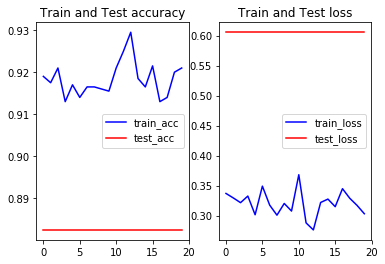

In [8]:
plot_training(history_ft)

In [10]:
# 很明显，这个训练有问题，在测试集上的表现一直没有变化，本来我想删除上面的结果，重新来做一遍，但考虑也许以后也会有人碰到同样的情况，故而保留。
# 通过print(len(my_model.layers))可以发现my_model整个的层数是20层，上面我们设置25层都不是trainable，所以把整个网络层都freeze掉，
# 这样就不能更改其中的weights,所以每次在test set上的表现都一样，都是用最原始的weights来测试。

In [13]:
# 上面的build_model2中间的my_model.layers[:25]要修改为my_model.layers[:15]，原博文此处也是错的。
# 4，构建模型
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras import optimizers
from keras.models import Model
def build_model2():
    base_model = applications.VGG16(weights='imagenet', include_top=False,input_shape=(IMG_W, IMG_H,IMG_CH))
    # 此处我们只需要卷积层不需要全连接层，故而inclue_top=False,一定要设置input_shape，否则后面会报错
    # 这一步使用applications模块自带的VGG16函数直接加载了模型和参数，作为我们自己模型的“身子”
    
    # 下面定义我们自己的分类器，作为我们自己模型的“头”
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:])) # 如果没有设置input_shape,这个地方报错，显示output_shape有很多None
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid')) # 二分类问题
    
    top_model.load_weights('E:\PyProjects\DataSet\FireAI\DeepLearning\FireAI006/top_FC_model') 
    # 上面定义了模型结构，此处要把训练好的参数加载进来，
    
    my_model = Model(inputs=base_model.input, outputs=top_model(base_model.output)) # 将“身子”和“头”组装到一起
    # my_model就是我们组装好的完整的模型，也已经加载了各自的weights
    
    # 普通的模型需要对所有层的weights进行训练调整，但是此处我们只调整VGG16的后面几个卷积层，所以前面的卷积层要冻结起来
    for layer in my_model.layers[:15]: # 15层之前都是不需训练的，原博文此处也是错的。我晕。。。。
        layer.trainable = False
        
    # 模型的配置
    my_model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), # 使用一个非常小的lr来微调
                  metrics=['accuracy'])
    return my_model

In [14]:
# 开始用train set来微调模型的参数
print('start to train model2')
my_model2=build_model2()
history_ft2 = my_model2.fit_generator(
        train_generator,
        steps_per_epoch=train_samples_num // batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_samples_num // batch_size)

start to train model2
Epoch 1/20
125/125 [==============================] - 727s 6s/step - loss: 0.3288 - acc: 0.8865 - val_loss: 0.2991 - val_acc: 0.9113
Epoch 2/20
125/125 [==============================] - 732s 6s/step - loss: 0.1822 - acc: 0.9395 - val_loss: 0.2988 - val_acc: 0.9113
Epoch 3/20
125/125 [==============================] - 724s 6s/step - loss: 0.1557 - acc: 0.9445 - val_loss: 0.2742 - val_acc: 0.9125
Epoch 4/20
125/125 [==============================] - 726s 6s/step - loss: 0.1206 - acc: 0.9550 - val_loss: 0.3038 - val_acc: 0.9200
Epoch 5/20
125/125 [==============================] - 731s 6s/step - loss: 0.0977 - acc: 0.9685 - val_loss: 0.2691 - val_acc: 0.9225
Epoch 6/20
125/125 [==============================] - 715s 6s/step - loss: 0.0738 - acc: 0.9745 - val_loss: 0.3476 - val_acc: 0.9113
Epoch 7/20
125/125 [==============================] - 711s 6s/step - loss: 0.0916 - acc: 0.9690 - val_loss: 0.2683 - val_acc: 0.9263
Epoch 8/20
125/125 [===========================

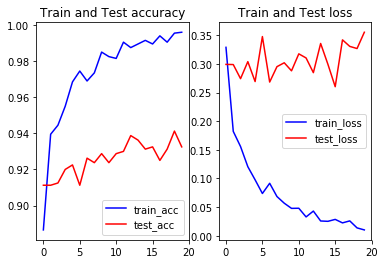

In [15]:
plot_training(history_ft2)